# Training a neural network to predict the value of the Nino34 index

##### SST mean data downloaded from NOAA NCEI Extended Reconstructed Sea Surface Temperature
* https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html

##### Nino34 Index calculation computed generally following below website, but included detrending data
* https://foundations.projectpythia.org/core/xarray/enso-xarray.html

In [1]:
%pip install seaborn cartopy fsspec requests aiohttp h5netcdf

import xarray as xr
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.colors as mcolors

import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
from sklearn.metrics import confusion_matrix

Note: you may need to restart the kernel to use updated packages.


# Preprocess Data

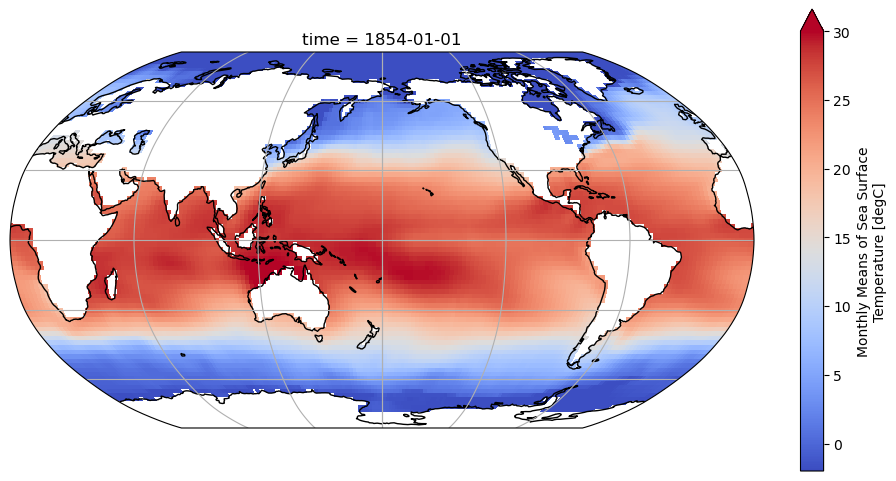

In [2]:
# sst_data_raw = xr.open_dataset("sst.mnmean.nc") # if stored locally

url = "https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mnmean.nc"
sst_data_raw = xr.open_dataset(fsspec.open(url).open())
sst_ds = sst_data_raw.sst

# Plot the first time step of the SST data
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.coastlines()
ax.gridlines()
sst_ds.isel(time=0).plot(
    ax=ax, transform=ccrs.PlateCarree(), vmin=-2, vmax=30, cmap="coolwarm"
)

## Compute monthly anomalies via removing climatology (1970-1999) for area averaged total SST from Nino34 region

In [3]:
# Select Baseline Period to Compute Climatology
sst_data_climo_slice = sst_ds.sel(time=slice("1970-01-01", "1999-12-31"))

# Compute the monthly climatology over selected period
climatology = sst_data_climo_slice.groupby("time.month").mean(dim="time")

# Calculate anomalies by removing the monthly climatology from the original SST data
tos_nino34_anom = sst_ds.groupby("time.month") - climatology

## Compute area-averaged total SST from Nino34 region

In [4]:
index_nino34 = tos_nino34_anom.sel(
    lat=slice(5, -5), lon=slice(190, 240)
)  # use lat/lon coordinates of specified region

weights = np.cos(
    np.deg2rad(tos_nino34_anom["lat"])
)  # weights for the cosine of latitude

tos_nino34 = index_nino34.weighted(weights).mean(("lon", "lat"))

## Detrend the data to remove the influence of long-term climate change

Slope of the linear trend: 0.0004


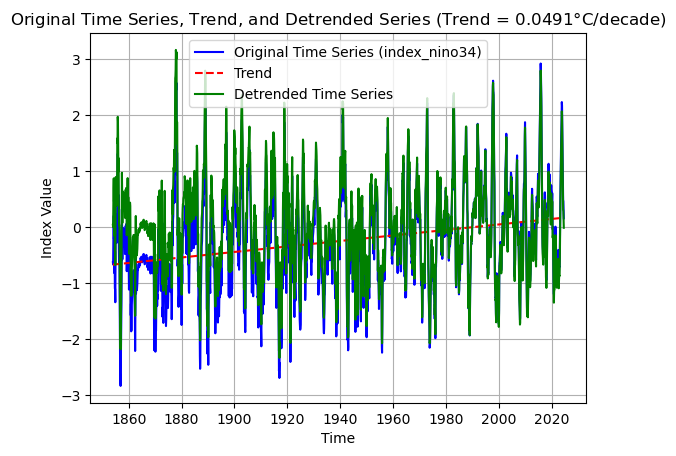

In [5]:
# Detrending the time series by first calculating the linear trend
time_numeric = np.arange(len(tos_nino34.time))

# Fit a linear regression to the time series to get the trend
coeffs = np.polyfit(time_numeric, tos_nino34, 1)  # Linear fit (degree=1)

# Extract the slope and intercept
slope = coeffs[0]  # Slope of the trend line
intercept = coeffs[1]  # Intercept of the trend line

# Create the trend line
trend = slope * time_numeric + intercept  # Create the trend line

# Detrend the time series by subtracting the trend from the original data
detrended_nino34 = tos_nino34 - trend

# Compute R-squared value
ss_res = np.sum((tos_nino34 - trend) ** 2)  # Residual sum of squares (SS_res)
ss_tot = np.sum(
    (tos_nino34 - np.mean(index_nino34)) ** 2
)  # Total sum of squares (SS_tot)
r_squared = 1 - (ss_res / ss_tot)

# Print the R² value
print(f"Slope of the linear trend: {slope:.4f}")

plt.plot(
    index_nino34.time,
    tos_nino34,
    label="Original Time Series (index_nino34)",
    color="blue",
)
plt.plot(index_nino34.time, trend, label="Trend", color="red", linestyle="--")
plt.plot(
    index_nino34.time, detrended_nino34, label="Detrended Time Series", color="green"
)

plt.title(
    f"Original Time Series, Trend, and Detrended Series (Trend = {slope*120:.4f}"
    + r"$\degree$C/decade)"
)
plt.xlabel("Time")
plt.ylabel("Index Value")
plt.legend()
plt.grid(True)
plt.show()

## Smooth data with a 5-month running mean

In [6]:
# Smooth the index with a 5-month rolling mean
nino34 = detrended_nino34.rolling(time=5, center=False).mean()

## Plot Nino 3.4 Index to visualize data

Text(0.5, 1.0, 'Niño 3.4 Index')

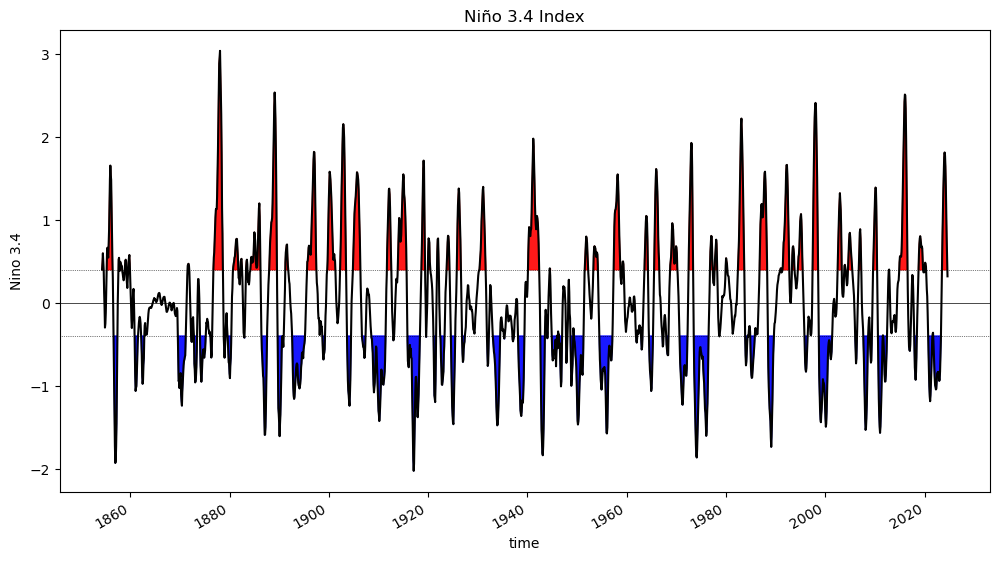

In [7]:
fig = plt.figure(figsize=(12, 6))

plt.fill_between(
    nino34.time.data,
    nino34.where(nino34 >= 0.4).data,
    0.4,
    color="red",
    alpha=0.9,
)
plt.fill_between(
    nino34.time.data,
    nino34.where(nino34 <= -0.4).data,
    -0.4,
    color="blue",
    alpha=0.9,
)

nino34.plot(color="black")
plt.ylabel("Nino 3.4")
plt.axhline(0, color="black", lw=0.5)
plt.axhline(0.4, color="black", linewidth=0.5, linestyle="dotted")
plt.axhline(-0.4, color="black", linewidth=0.5, linestyle="dotted")
plt.title("Niño 3.4 Index")

# Split Data into train/val/test

In [8]:
# Drop NaNs
nino34 = nino34.dropna(dim="time")

lead = 1  # number of months ahead to predict

# Prepare the data: input is all months except the last; output is the following month's value
nino34_X = nino34[:-lead]
nino34_Y = nino34[lead:]  # All but the first month (output is shifted by 1)

# Ensure nino34_X and nino34_Y are the same length and time-aligned
nino34_X["time"] = nino34_X.time.values  # Align nino34_X's time with its original time
nino34_Y["time"] = nino34_Y.time.values  # Ensure nino34_Y has the correct time values

# Get the years from the time coordinate (based on nino34_X)
years = np.array(sorted(np.unique(nino34_X.time.dt.year.values)))

# Calculate the number of years for each split
train_size = int(
    0.7 * len(years)
)  # 70% for training; takes integer value for closest year split
val_size = int(0.15 * len(years))  # 15% for validation
test_size = len(years) - train_size - val_size  # The rest for testing

# Split the years sequentially
train_years = years[:train_size]
val_years = years[train_size : train_size + val_size]
test_years = years[train_size + val_size :]

# Create boolean masks to select data by year using xarray DataArrays for X (input)
train_mask_X = xr.DataArray(
    np.isin(nino34_X.time.dt.year, train_years),
    dims="time",
    coords={"time": nino34_X.time},
)
val_mask_X = xr.DataArray(
    np.isin(nino34_X.time.dt.year, val_years),
    dims="time",
    coords={"time": nino34_X.time},
)
test_mask_X = xr.DataArray(
    np.isin(nino34_X.time.dt.year, test_years),
    dims="time",
    coords={"time": nino34_X.time},
)

# Apply masks to get training, validation, and testing sets (dropping the unmatched time points)
X_train = nino34_X.where(train_mask_X, drop=True)
X_val = nino34_X.where(val_mask_X, drop=True)
X_test = nino34_X.where(test_mask_X, drop=True)

Y_train = nino34_Y[: len(X_train.time)]
Y_val = nino34_Y[len(X_train.time) : len(X_train.time) + len(X_val.time)]
Y_test = nino34_Y[len(X_train.time) + len(X_val.time) :]

# Verify shapes
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

X_train shape: (1424,), Y_train shape: (1424,)
X_val shape: (300,), Y_val shape: (300,)
X_test shape: (319,), Y_test shape: (319,)


## Normalize data with training data standard deviation

In [9]:
# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)

# Normalize SST data using the training standard deviation (sst_std)
X_std = np.std(X_train, axis=0)

# Standardize the train, validation, and test data by dividing by sst_std
X_train = np.divide(X_train, X_std)
X_train[np.isnan(X_train)] = 0  # Set NaNs to zero in the training data

X_val = np.divide(X_val, X_std)
X_val[np.isnan(X_val)] = 0  # Set NaNs to zero in the validation data

X_test = np.divide(X_test, X_std)
X_test[np.isnan(X_test)] = 0  # Set NaNs to zero in the test data

# Need to convert xarray DataArray to NumPy arrays using the .values attribute
X_train_np = X_train.values  # Extract NumPy array from xarray DataArray
Y_train_np = Y_train.values  # Similarly for labels

X_val_np = X_val.values
Y_val_np = Y_val.values

X_test_np = X_test.values
Y_test_np = Y_test.values

# Reshape the data to ensure each sample has one feature
X_train_np = X_train_np.reshape(-1, 1)
X_val_np = X_val_np.reshape(-1, 1)
X_test_np = X_test_np.reshape(-1, 1)
print(X_train_np.shape)  # Should be (num_samples, num_features)
print(Y_train_np.shape)  # Should be (num_samples,)

## Plot data to visualize data split

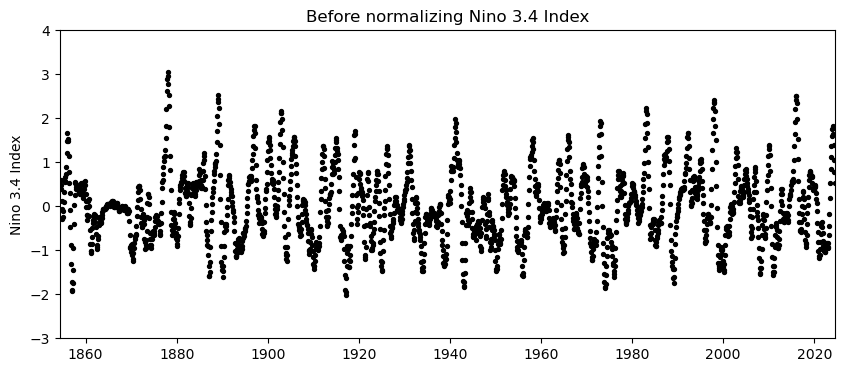

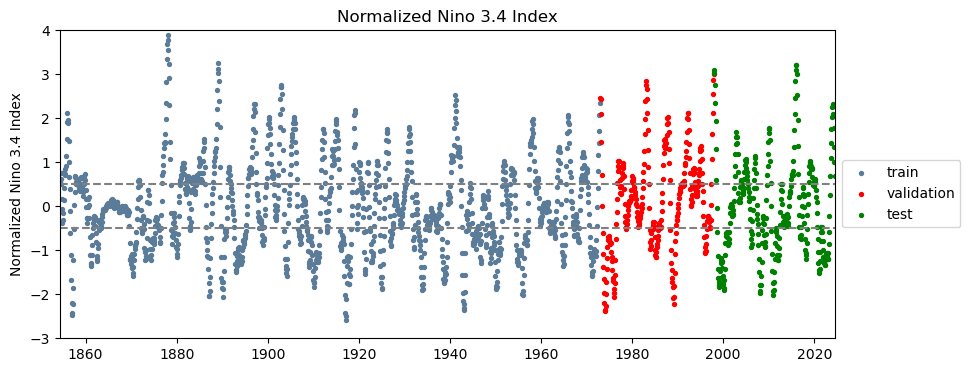

In [11]:
# Ensure that the time coordinate is properly accessed and handled
time_data = nino34.time.values[:-1]
nino34_plot = nino34.values[:-1]

# Plot scatter plot for training data
plt.figure(figsize=(10, 4))
plt.scatter(
    time_data[train_mask_X.values],
    nino34_plot[train_mask_X.values],
    color="black",
    s=8,
)

# Plot scatter plot for validation data
plt.scatter(
    time_data[val_mask_X.values],
    nino34_plot[val_mask_X.values],
    color="black",
    s=8,
)

# Plot scatter plot for test data
plt.scatter(
    time_data[test_mask_X.values],
    nino34_plot[test_mask_X.values],
    color="black",
    s=8,
)

plt.title("Before normalizing Nino 3.4 Index")
plt.xlim(time_data[0], time_data[-1])
plt.ylim(-3, 4)
plt.ylabel("Nino 3.4 Index")


# Plot scatter plot for training data
plt.figure(figsize=(10, 4))
plt.scatter(
    time_data[train_mask_X.values],
    X_train,
    color="xkcd:slate blue",
    s=8,
    label="train",
)

# Plot scatter plot for validation data
plt.scatter(
    time_data[val_mask_X.values],
    X_val,
    color="red",
    s=8,
    label="validation",
)

# Plot scatter plot for test data
plt.scatter(
    time_data[test_mask_X.values],
    X_test,
    color="green",
    s=8,
    label="test",
)
plt.title("Normalized Nino 3.4 Index")
# Set plot limits and labels
plt.xlim(time_data[0], time_data[-1])
plt.ylim(-3, 4)
plt.ylabel("Normalized Nino 3.4 Index")

# Add horizontal lines for El Niño and La Niña thresholds for visualization
plt.hlines(0.5, X_train.time[0], X_test.time[-1], linestyle="dashed", color="grey")
plt.hlines(-0.5, X_train.time[0], X_test.time[-1], linestyle="dashed", color="grey")

# Add legend
plt.legend(bbox_to_anchor=(1, 0.4, 0.1, 0.2))

# Show the plot
plt.show()
plt.show()

# Neural Network Setup

##### The preprocessing of the input and output data is complete. Now, we set up the neural networks to made our predictions.

## Hyperparameter Selection

In [12]:
# Define hyperparameters
input_size = X_train_np.shape[1]
hiddens = [12, 12]
output_size = 1  # only predicting one value for each prediction
learning_rate = 0.001
n_epochs = 40
batch_size = 32
l2_reg = 0.01  # L2 regularization (weight decay)

In [13]:
class ENSOPredictor_Regression(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size):
        super(ENSOPredictor_Regression, self).__init__()
        self.layers = nn.ModuleList()

        # Add the first hidden layer
        self.layers.append(nn.Linear(input_size, hidden_layers[0]))

        # Add additional hidden layers
        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))

        # Add the output layer (no softmax for regression)
        self.layers.append(nn.Linear(hidden_layers[-1], output_size))

    def forward(self, x):
        # Pass input through each hidden layer with ReLU activation
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        # Output layer (no activation for regression)
        return self.layers[-1](x)

Epoch 1/40, Train Loss: 0.4745748665597704, Val Loss: 0.43368201740086076, Train MSE: 0.4745748665597704, Val MSE: 0.43368201740086076
Epoch 2/40, Train Loss: 0.26463688363631566, Val Loss: 0.1936611318960786, Train MSE: 0.26463688363631566, Val MSE: 0.1936611318960786
Epoch 3/40, Train Loss: 0.10490788552496168, Val Loss: 0.0752044714987278, Train MSE: 0.10490788552496168, Val MSE: 0.0752044714987278
Epoch 4/40, Train Loss: 0.046261236319939295, Val Loss: 0.0498142478056252, Train MSE: 0.046261236319939295, Val MSE: 0.0498142478056252
Epoch 5/40, Train Loss: 0.03586640598045455, Val Loss: 0.04396699704229832, Train MSE: 0.03586640598045455, Val MSE: 0.04396699704229832
Epoch 6/40, Train Loss: 0.03265065710163779, Val Loss: 0.041247276775538924, Train MSE: 0.03265065710163779, Val MSE: 0.041247276775538924
Epoch 7/40, Train Loss: 0.03192971195611689, Val Loss: 0.03982321824878454, Train MSE: 0.03192971195611689, Val MSE: 0.03982321824878454
Epoch 8/40, Train Loss: 0.03023407297829787, 

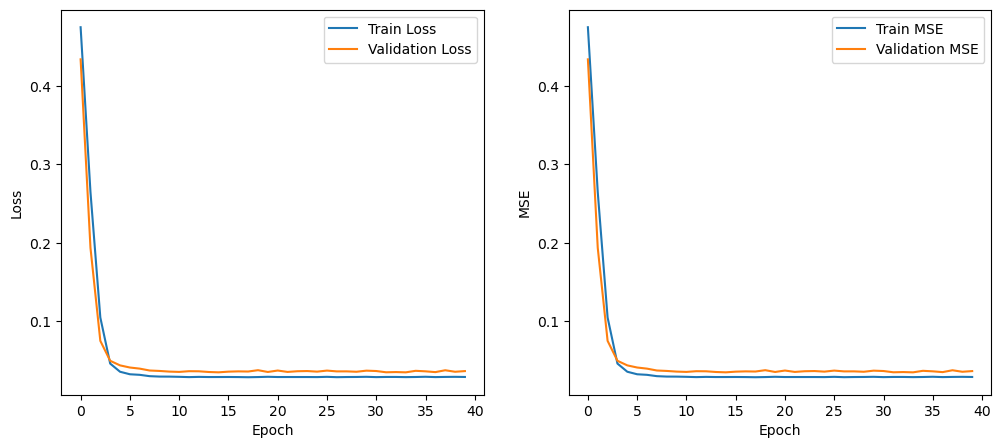

In [14]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).reshape(-1, 1)
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.float32).reshape(-1, 1)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).reshape(-1, 1)
Y_val_tensor = torch.tensor(Y_val.values, dtype=torch.float32).reshape(-1, 1)

# DataLoader for batching
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor),
    batch_size=batch_size,
    shuffle=True,
)

val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_val_tensor, Y_val_tensor),
    batch_size=batch_size,
    shuffle=False,
)

# Initialize the model, loss function, and optimizer
model = ENSOPredictor_Regression(input_size, hiddens, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg)

# Training loop
train_losses = []
val_losses = []
train_mses = []
val_mses = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    running_mse = 0.0
    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_mse += ((outputs - labels) ** 2).mean().item()

    # Calculate validation loss and MSE
    model.eval()
    val_loss = 0.0
    val_mse = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_mse += ((outputs - labels) ** 2).mean().item()

    # Append the metrics for plotting
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    train_mses.append(running_mse / len(train_loader))
    val_mses.append(val_mse / len(val_loader))

    print(
        f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train MSE: {train_mses[-1]}, Val MSE: {val_mses[-1]}"
    )

# Plot the training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot the training and validation MSE
plt.subplot(1, 2, 2)
plt.plot(train_mses, label="Train MSE")
plt.plot(val_mses, label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()

plt.show()

## Evaluate the model on the test set

In [15]:
test_data = torch.tensor(X_test_np, dtype=torch.float32)  # Feature data for testing
test_labels = torch.tensor(Y_test_np, dtype=torch.long)  # Testing labels

# Create the test dataset and loader
test_dataset = TensorDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Set the model to evaluation mode
model.eval()

# To store predictions and original indices
predictions = []
original_indices = []

with torch.no_grad():  # No need to track gradients during evaluation
    for batch_idx, (data, labels) in enumerate(test_loader):
        # Get the original indices of the current batch
        original_indices.extend(batch_idx * batch_size + torch.arange(data.size(0)))

        # Forward pass to get predictions
        output = model(data)
        predictions.append(output)

# Concatenate the predictions and convert to a tensor
predictions = torch.cat(predictions, dim=0)

# Convert original indices to a tensor for easy indexing if needed
original_indices = torch.tensor(original_indices)

# Now predictions contains the model's outputs, and original_indices contains the indices
# print("Predictions:", predictions)
# print("Original Indices:", original_indices)

## Plot the predictions vs. truth

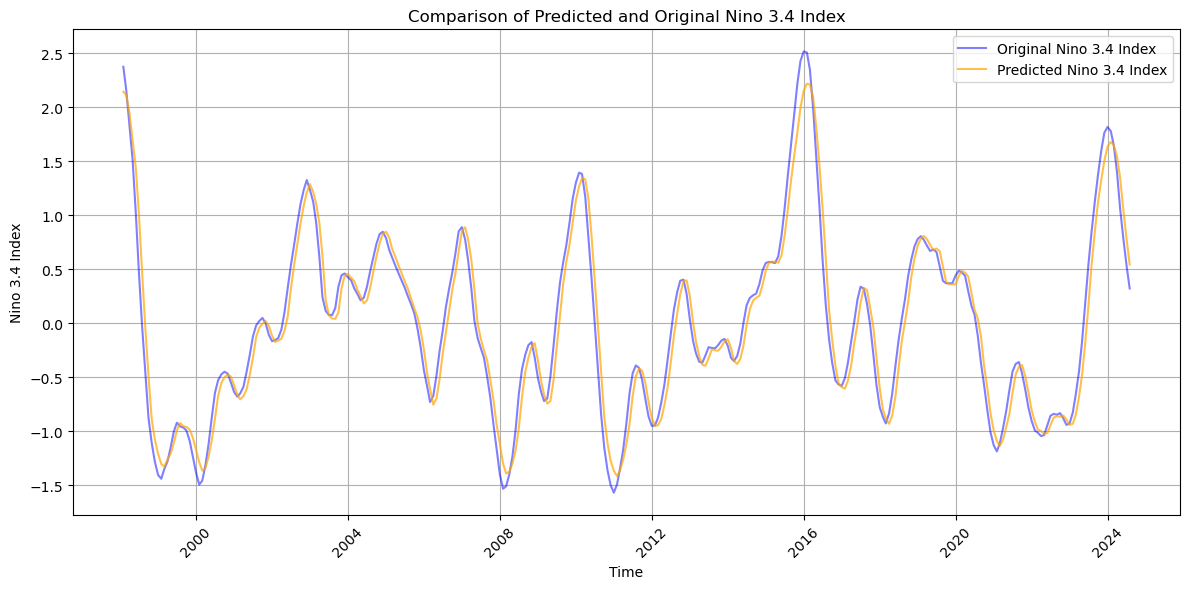

In [16]:
time_nino34 = Y_test.time.values

start_index = len(Y_test) - len(predictions)
time_predictions = time_nino34[start_index:]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(time_nino34, Y_test, label="Original Nino 3.4 Index", color="blue", alpha=0.5)
plt.plot(
    time_predictions,
    predictions,
    label="Predicted Nino 3.4 Index",
    color="orange",
    alpha=0.7,
)

# Add labels and title
plt.title("Comparison of Predicted and Original Nino 3.4 Index")
plt.xlabel("Time")
plt.ylabel("Nino 3.4 Index")
plt.legend()
plt.grid()

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.tight_layout()  # Adjust layout for better fit
plt.show()